In [1]:
import warnings
import sys
import shutil

shutil.copy2('./../../myCBR_projects/userKnowledgeModeling_yedek.prj', './../../myCBR_projects/userKnowledgeModeling.prj') # complete target filename given

warnings.filterwarnings("ignore")
sys.path.append('../../')
sys.path.append('../')

In [2]:
import seaborn as sns
import random
import pickle
from PertCF import *

In [3]:
# Set random seed
random_state = random.randint(0, 100)

# Concept name
concept = 'knowledge'
column_names = ['STG','SCG','STR','LPR','PEG','UNS']
class_names = ['0','1','2','3']
cat_feat = []

# Read data
train = pd.read_pickle('./Data/unm_train.pkl')
test =  pd.read_pickle('./Data/unm_test.pkl')

train_cols = train.columns[0:-1]
label = train.columns[-1]

X_train, X_test, y_train, y_test = train[train_cols], test[train_cols], train[[label]], test[[label]]


In [4]:
def rev(dic):
    return {v: k for k, v in dic.items()}

# from categoric features to numeric features with maps
# from numeric features to categoric features with inv_maps
def encode(df, maps):
    for i in cat_feat:
        df[i] = df[i].map(maps[i]).astype('float')
    return df

maps = {}
inv_maps = {}

# encoding for training the model
#X_en = encode(X.copy(), maps)
X_train_en, X_test_en = encode(X_train.copy(), maps), encode(X_test.copy(), maps)
train_en = encode(train.copy(), maps)
test_en = encode(test.copy(), maps)

In [5]:
# load model
model = pickle.load(open('./Model/model_GBC.pkl', "rb"))

# load shap_df
shap_df = pd.read_pickle("./temp_files/shap_df.pkl")

In [6]:
explainer = Explainer(model, X_train, X_test, y_train, y_test, label, cat_feat, concept, shap_df=shap_df, maps=maps, inv_maps=inv_maps, num_iter=5)


Given Shap values used.

API connection completed.

Concept names:  ['knowledge']  Is correct:  True 

Casebase names:  [['cb_class1'], ['cb_class0'], ['cb_class3'], ['cb_class2']] 

Cases deleted from concept 'knowledge': True

Cases imported to the casebases. 

Amalgamation functions created for every class using shap values. 



In [7]:
cf_list, res_list = explainer.testGenerateCF(coef_thresh = 3)

3


In [8]:
res_list

[0.06363029671641043,
 0.05853658536585366,
 0.06643612746207715,
 0.2827342428812167]

In [27]:
res_list

[0.06363029671641043,
 0.05853658536585366,
 0.06643612746207715,
 0.30523154793716056]

-----------

### DICE

In [9]:
import dice_ml

# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_en,
                 continuous_features=column_names[:-1],
                 outcome_name=label)

# Pre-trained ML model
m = dice_ml.Model(model=model,backend='sklearn')
# DiCE explanation instance
dice_exp = dice_ml.Dice(d,m)

In [10]:
dis_q = []
spar_q = []
ins_q = []
time_q = []

for i in range(len(y_test)):
    query_instance = test_en.drop(columns=label)[i:i+1]
    q_lbl = model.predict(query_instance)[0]#test_en[label][i:i+1].iloc[0]
    
    t_time = 0

    for j in class_names:
        if j != q_lbl:
            start = t.time()
            cf = dice_exp.generate_counterfactuals(query_instance, total_CFs=1, desired_class=int(j)).cf_examples_list[0].final_cfs_df
            end = t.time()

            for col in explainer.cat_col_names:
                cf[col] = cf[col].map(inv_maps[col])
                query_instance[col] = query_instance[col].map(inv_maps[col])

            dis_q.append(explainer.dissimilarity(query_instance.iloc[0],cf.iloc[0])) 
            #den._findSimilarity(query_instance.iloc[0],cf.iloc[0])
            spar_q.append(explainer.sparsity(query_instance.iloc[0],cf.iloc[0]))
            ins_q.append(explainer.instability(query_instance.iloc[0],cf.iloc[0]))
            t_time += end - start

    time_q.append(t_time)



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


In [11]:
print('Dissimilarity:', mean(dis_q), 
     '\nSparsity:', mean(spar_q), 
     '\nInstabilty:', mean(ins_q),
     '\nTime:', mean(time_q))

Dissimilarity: 0.17272092236499165 
Sparsity: 0.6422764227642276 
Instabilty: 0.17689593510392093 
Time: 0.11794748538877906


In [12]:
dice_res = [mean(dis_q),mean(spar_q),mean(ins_q), mean(time_q)]

---

### CF Shap

In [13]:
from shap import Explanation

from cfshap.utils import attrdict
from cfshap.utils.preprocessing import EfficientQuantileTransformer
from cfshap.counterfactuals import KNNCounterfactuals
from cfshap.attribution import TreeExplainer, CompositeExplainer
from cfshap.trend import TrendEstimator

In [14]:
MAX_SAMPLES = 100

# We will need a scaler in the input space for the counterfactual generator
scaler = EfficientQuantileTransformer()
scaler.fit(X_train_en.values)


EfficientQuantileTransformer()

In [15]:

# Background/Counterfactuals generator
background_generator = KNNCounterfactuals(
    model=model,
    X=X_train_en.values,
    n_neighbors=10,
    distance='cityblock',
    scaler=scaler,
    max_samples=MAX_SAMPLES,
)

# We will need a trend estimator for the attribution estimator
trend_estimator = TrendEstimator(strategy='mean')



In [16]:
dis_q = []
spar_q = []
ins_q = []
time_q = []

for i in range(len(y_test)):
    query_instance = X_test_en.iloc[i:i+1]

    start = t.time()
    cf = background_generator.get_counterfactuals(query_instance.values)
    end = t.time()

    cf = pd.DataFrame(cf, columns = column_names[:-1])

    for col in explainer.cat_col_names:
        cf[col] = cf[col].map(inv_maps[col])
        query_instance[col] = query_instance[col].map(inv_maps[col])
       
    dis_q.append(explainer.dissimilarity(query_instance.iloc[0],cf.iloc[0])) 
    spar_q.append(explainer.sparsity(query_instance.iloc[0],cf.iloc[0]))
    ins_q.append(explainer.instability(query_instance.iloc[0],cf.iloc[0]))
    time_q.append(end - start)


In [17]:
print('Dissimilarity:', mean(dis_q), 
     '\nSparsity:', mean(spar_q), 
     '\nInstabilty:', mean(ins_q),
     '\nTime:', mean(time_q))

Dissimilarity: 0.17917226203690792 
Sparsity: 0.02926829268292683 
Instabilty: 0.18061823880724262 
Time: 0.0011229573226556545


In [18]:
cf_res = [mean(dis_q),mean(spar_q),mean(ins_q), mean(time_q)]

In [19]:
shutil.copy2('./../../myCBR_projects/userKnowledgeModeling_yedek.prj', './../../myCBR_projects/userKnowledgeModeling.prj') # complete target filename given

'./../../myCBR_projects/userKnowledgeModeling.prj'

In [32]:
df = pd.DataFrame([cf_res,dice_res,res_list], columns=['dissimilarity', 'sparsity', 'instability', 'time'])
df['model'] = ['CFshap','DICE','PertCF']

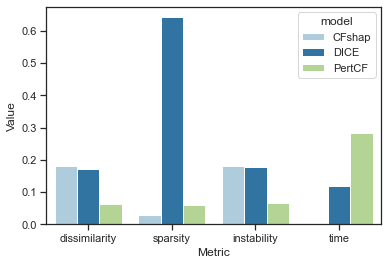

In [45]:
sns.set_style("ticks")
sns.set_context("notebook")

sns.barplot(data=df.melt('model'), x="variable", y='value', hue="model", palette = 'Paired')


plt.xlabel('Metric')
plt.ylabel('Value')
#plt.title('tt')

plt.savefig('./Output/img/omparison_result.png', dpi=1200, bbox_inches='tight')
#display barplot
plt.show()

In [34]:
df

,dissimilarity,sparsity,instability,time,model
0,0.179172,0.029268,0.180618,0.001123,CFshap
1,0.172721,0.642276,0.176896,0.117947,DICE
2,0.063630,0.058537,0.066436,0.282734,PertCF
